# **micrograd** autograd engine

In [1]:
import math
import numpy as np

### derivative of a simple function with one input

In [2]:
def f(x):
    return x**2 - 2*x + 1

In [3]:
import numpy as np
xs =  np.arange(start=-5, stop=5, step=0.25)
ys = f(xs)

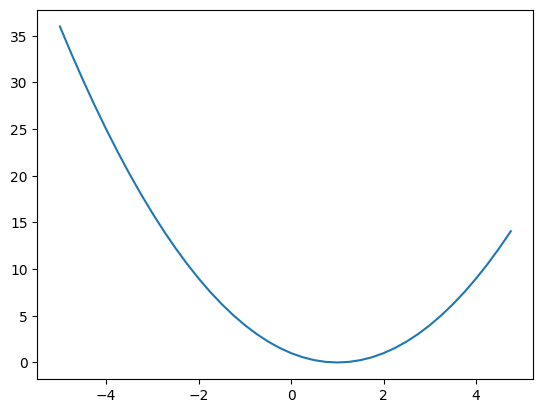

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xs, ys);

In [5]:
x = 1.0
h = 0.00000001
slope = (f(x+h) - f(x)) / h 
slope

0.0

### derivative of a function with multiple inputs

In [6]:
h = 0.000001
for i in range(3):
    a = [2.0, -3.0, 10.0]
    d1 = a[0]*a[1] + a[2]
    a[i] += h
    d2 = a[0]*a[1] + a[2]
    print(f'slope: {round((d2-d1)/h, 2)}')


slope: -3.0
slope: 2.0
slope: 1.0


### starting the core Value object of micrograd and its visualization

In [7]:
class Value:

    def __init__(self, data, _children=tuple(), _op=str(), label=str()):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')
        return out

In [8]:
a = Value(1.2)
b = Value(3.4)
c = Value(5.6)

d = a * b + c
d, d._prev, d._op

(Value(data=9.68), {Value(data=4.08), Value(data=5.6)}, '+')

### manual backpropagation example #1: simple expression

In [9]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a * b; d.label = 'c'
d = Value(10.0, label='d')
e = c + d; e.label = 'e'
f = Value(-2.0, label='f')
L = e * f; L.label = 'L'

*manual derivatives*

dL/dL = 1.0 <br>
dL/df = d(e * f)/df = e <br>
dL/de = d(e * f)/de = f <br>
dL/dd = dL/de * de/dd = dL/de * 1.0 = f <br>
dL/dc = dL/de * de/dd = dL/de * 1.0 = f <br>
dL/db = dL/dc * dc/db = f * a <br>
dL/da = dL/dc * dc/da = f * b <br>

x.data = x.data + theta * x.grad 

In [10]:
L.grad = 1.0
f.grad = L.grad * e.data
e.grad = L.grad * f.data
d.grad = f.data
c.grad = f.data
b.grad = c.grad * a.data
a.grad = c.grad * b.data

### manual backpropagation example #2: a neuron

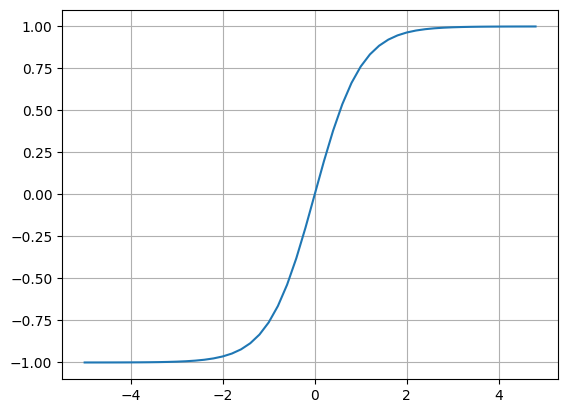

In [11]:
x = np.arange(-5, 5, 0.2)
y = np.tanh(x)
plt.plot(x, y);
plt.grid();

In [12]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# (x1.w1 + x2.w2) + b
x1w1 = x1*w1; x1w1.label = 'x1.w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'
x1w1x2w2 = x1w1 + x2w2; label = 'x1.w1 + x2.w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'
n.data, o.data

(0.8813735870195432, 0.7071067811865476)

*derivative of tanh (x)*

d(tanh (x))/dx = 1 - (tanh (x))^2

In [13]:
o.grad = 1
n.grad = 1 - o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [14]:
w1.grad, w2.grad

(0.9999999999999998, 0.0)